In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**载入相关的库**

In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F

In [5]:
# 数据类型
dtype = torch.FloatTensor()
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# 简易数据集
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is bad

In [7]:
# TextCNN 参数
embedding_size = 2                  # embedding维度为2
sequence_length = len(sentences[0]) # 统一句子长度
num_classes = len(set(labels))      # 分类的种数，set是一个不允许内容重复的组合，而且set里的内容位置是随意的，所以不能用索引列出
batch_size = 3                      # 每三句为一个batch

**词汇预处理**

In [8]:
word_list = " ".join(sentences).split()          # 通过空格将句子相互连起来，然后把它们分成单个的词
vocab = list(set(word_list))                     # 去重，转化为列表形式
word2idx = {i : j for j, i in enumerate(vocab)}  # 为单词添加索引，形成字典
vocab_size = len(vocab)                          # 词汇数量

In [9]:
word2idx

{'i': 0,
 'baseball': 1,
 'you': 2,
 'that': 3,
 'is': 4,
 'hate': 5,
 'he': 6,
 'sorry': 7,
 'loves': 8,
 'awful': 9,
 'love': 10,
 'this': 11,
 'for': 12,
 'likes': 13,
 'she': 14,
 'me': 15}

**数据预处理**

In [10]:
def make_data(sentences, labels):
    inputs = []
    for sen in sentences:
        inputs.append([word2idx[n] for n in sen.split()])     # 将句子中的词转换为index
        
    targets = []
    for out in labels:
        targets.append(out)
    return inputs, targets
input_batch, target_batch = make_data(sentences,labels)       
input_batch, target_batch = torch.LongTensor(input_batch), torch.LongTensor(target_batch)   # 转换数据类型为torch.Tensor

dataset = Data.TensorDataset(input_batch, target_batch)
loader = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

**构建网络**

In [14]:
class TextCNN(nn.Module):
    def __init__(self):
        """
        class torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2, scale_grad_by_freq=False, sparse=False)
        num_embeddings (int) - 嵌入字典的大小
        embedding_dim (int) - 每个嵌入向量的大小
        padding_idx (int, optional) - 如果提供的话，输出遇到此下标时用零填充
        """
        super(TextCNN,self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        output_channel = 3
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=output_channel, kernel_size = (2, embedding_size), stride=1),
            nn.ReLU(),                        
            nn.MaxPool2d((2, 1))
        )
        self.fc = nn.Linear(in_features=output_channel, out_features=num_classes) # 几个分类输出就是几
        
    def forward(self,x):
        batch_size = x.shape[0]                    # 输入的x，第一阶段它是在loader中，它的size是([3, 3])，第一个参数为batch_size,第二个参数为sequence_length
        embedding_x = self.embedding(x)            # 添加embedding维度，此时x的size为([3, 3, 2]),即batch_size * sequence_length * embedding_size
        initchannel_x = embedding_x.unsqueeze(1)   # unsqueeze在第1位上添加了一维，x现为batch_size*1*sequence*length*embedding_size,相当于初始化in_channel为1
        conved = self.convs(initchannel_x)         # 依次进入卷积，relu线性变换，最大池化，最后的维度为[batch_size,output_channel,1,1]即[3, 3, 1, 1]
        flatten = conved.view(batch_size, -1)      # 把数据压平，维度变为batch_size,-1，这里的-1相当于上面的output_channel*1*1,和第一阶段输入的维度相同
        output = self.fc(flatten)
        return output


**实例化网络**

In [15]:
model = TextCNN()
model.to(device)

TextCNN(
  (embedding): Embedding(16, 2)
  (convs): Sequential(
    (0): Conv2d(1, 3, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3, out_features=2, bias=True)
)

**构造损失函数和优化器**

In [16]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

**训练网络**

In [17]:
for epoch in range(5000):
    for train_x, train_y in loader:
        train_x, train_y = train_x.to(device), train_y.to(device)
        pred = model(train_x)
        loss = criterion(pred, train_y)
        if (epoch + 1) % 1000 == 0:   
            print("epoch:", "%04d" %(epoch + 1), "loss=","{:.6f}".format(loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

epoch: 1000 loss= 0.000036
epoch: 1000 loss= 0.000019
epoch: 2000 loss= 0.000007
epoch: 2000 loss= 0.000003
epoch: 3000 loss= 0.000002
epoch: 3000 loss= 0.000001
epoch: 4000 loss= 0.000000
epoch: 4000 loss= 0.000001
epoch: 5000 loss= 0.000000
epoch: 5000 loss= 0.000000


**测试网络**

In [26]:
test_text = "you hate me"
texts = [[word2idx[n] for n in test_text.split()]]
test_x = torch.LongTensor(texts).to(device)

In [36]:
model = model.eval()
"""
torch.max(input, dim, keepdim=False) → output tensors (max, max_indices)
input：输入的 tensor
dim：按什么维度求最大值（2D中，0代表按列求最大值，1代表按行求最大值）
keepdim：是否保持 input tensor 的维度，True 代表 out tensor 与 input tensor 的维度相同，False 代表 out tensor 与 input tensor 的维度不同
"""
predict = model(test_x).data.max(1, keepdim=True)[1]
if predict[0][0] == 0:
    print(test_text,"is negative")
else:
    print(test_text,"is positive")

you hate me is negative


**卷积运算**

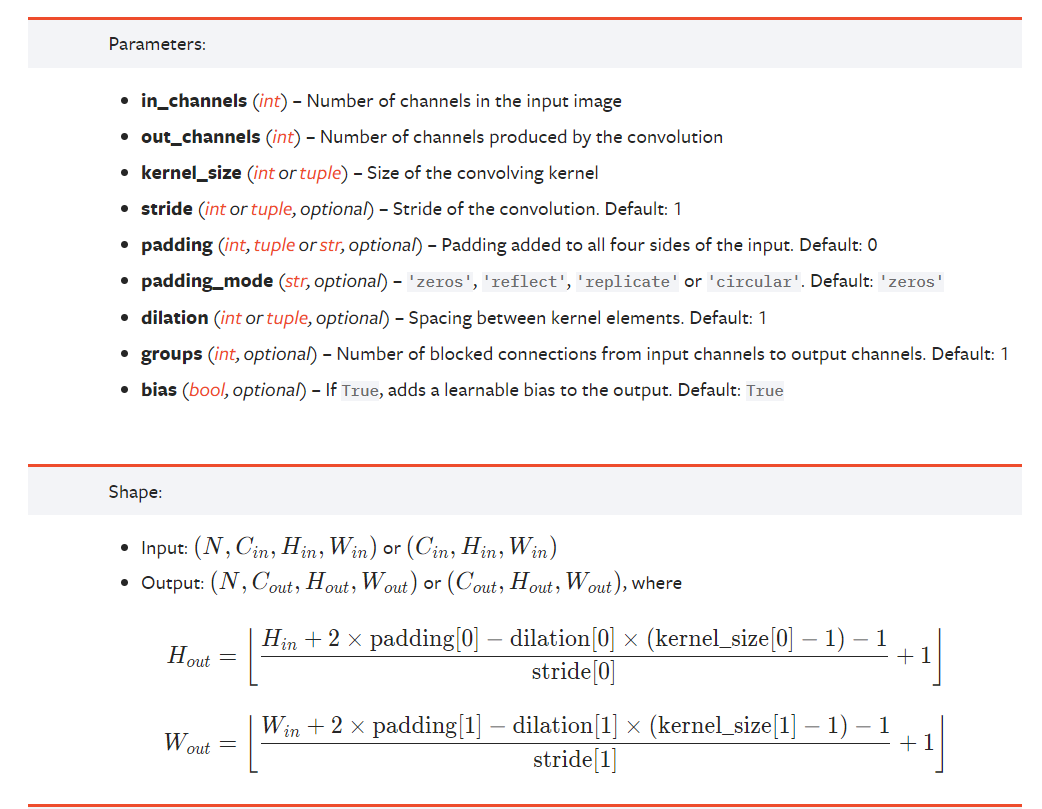